In [3]:
import sys
sys.path.append("/ssd5/Roy/pytorch_resnet_cifar10-master")
import resnet_cifar10
arch = "resnet56"
model = resnet_cifar10.__dict__[arch]()
print(model)

# ResNet
# ├── conv1 (3x3, stride=1)
# ├── bn1
# ├── layer1 (Residual Block, 16 filters)
# │   ├── Block 0
# │   ├── Block 1
# │   ├── Block 2
# │   ├── ...
# │   ├── Block 8
# ├── Layer2 (Residual Block, 32 filters)
# │   ├── Block 0
# │   ├── Block 1
# │   ├── ...
# │   ├── Block 8
# ├── Layer3 (Residual Block, 64 filters)
# │   ├── Block 0
# │   ├── Block 1
# │   ├── ...
# │   ├── Block 8
# └── Linear (Fully Connected, 10 classes)


ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [ ]:
import sys
sys.path.append("/ssd5/Roy/pytorch_resnet_cifar10-master")
import resnet_cifar10
arch = "resnet56"
model = resnet_cifar10.__dict__[arch]()
print(model)

# ResNet
# ├── conv1 (3x3, stride=1)
# ├── bn1
# ├── layer1 (Residual Block, 16 filters)
# │   ├── Block 0
# │   ├── Block 1
# │   ├── Block 2
# │   ├── ...
# │   ├── Block 8
# ├── Layer2 (Residual Block, 32 filters)
# │   ├── Block 0
# │   ├── Block 1
# │   ├── ...
# │   ├── Block 8
# ├── Layer3 (Residual Block, 64 filters)
# │   ├── Block 0
# │   ├── Block 1
# │   ├── ...
# │   ├── Block 8
# └── Linear (Fully Connected, 10 classes)


/tmp/ipykernel_3444778/1301725624.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


27


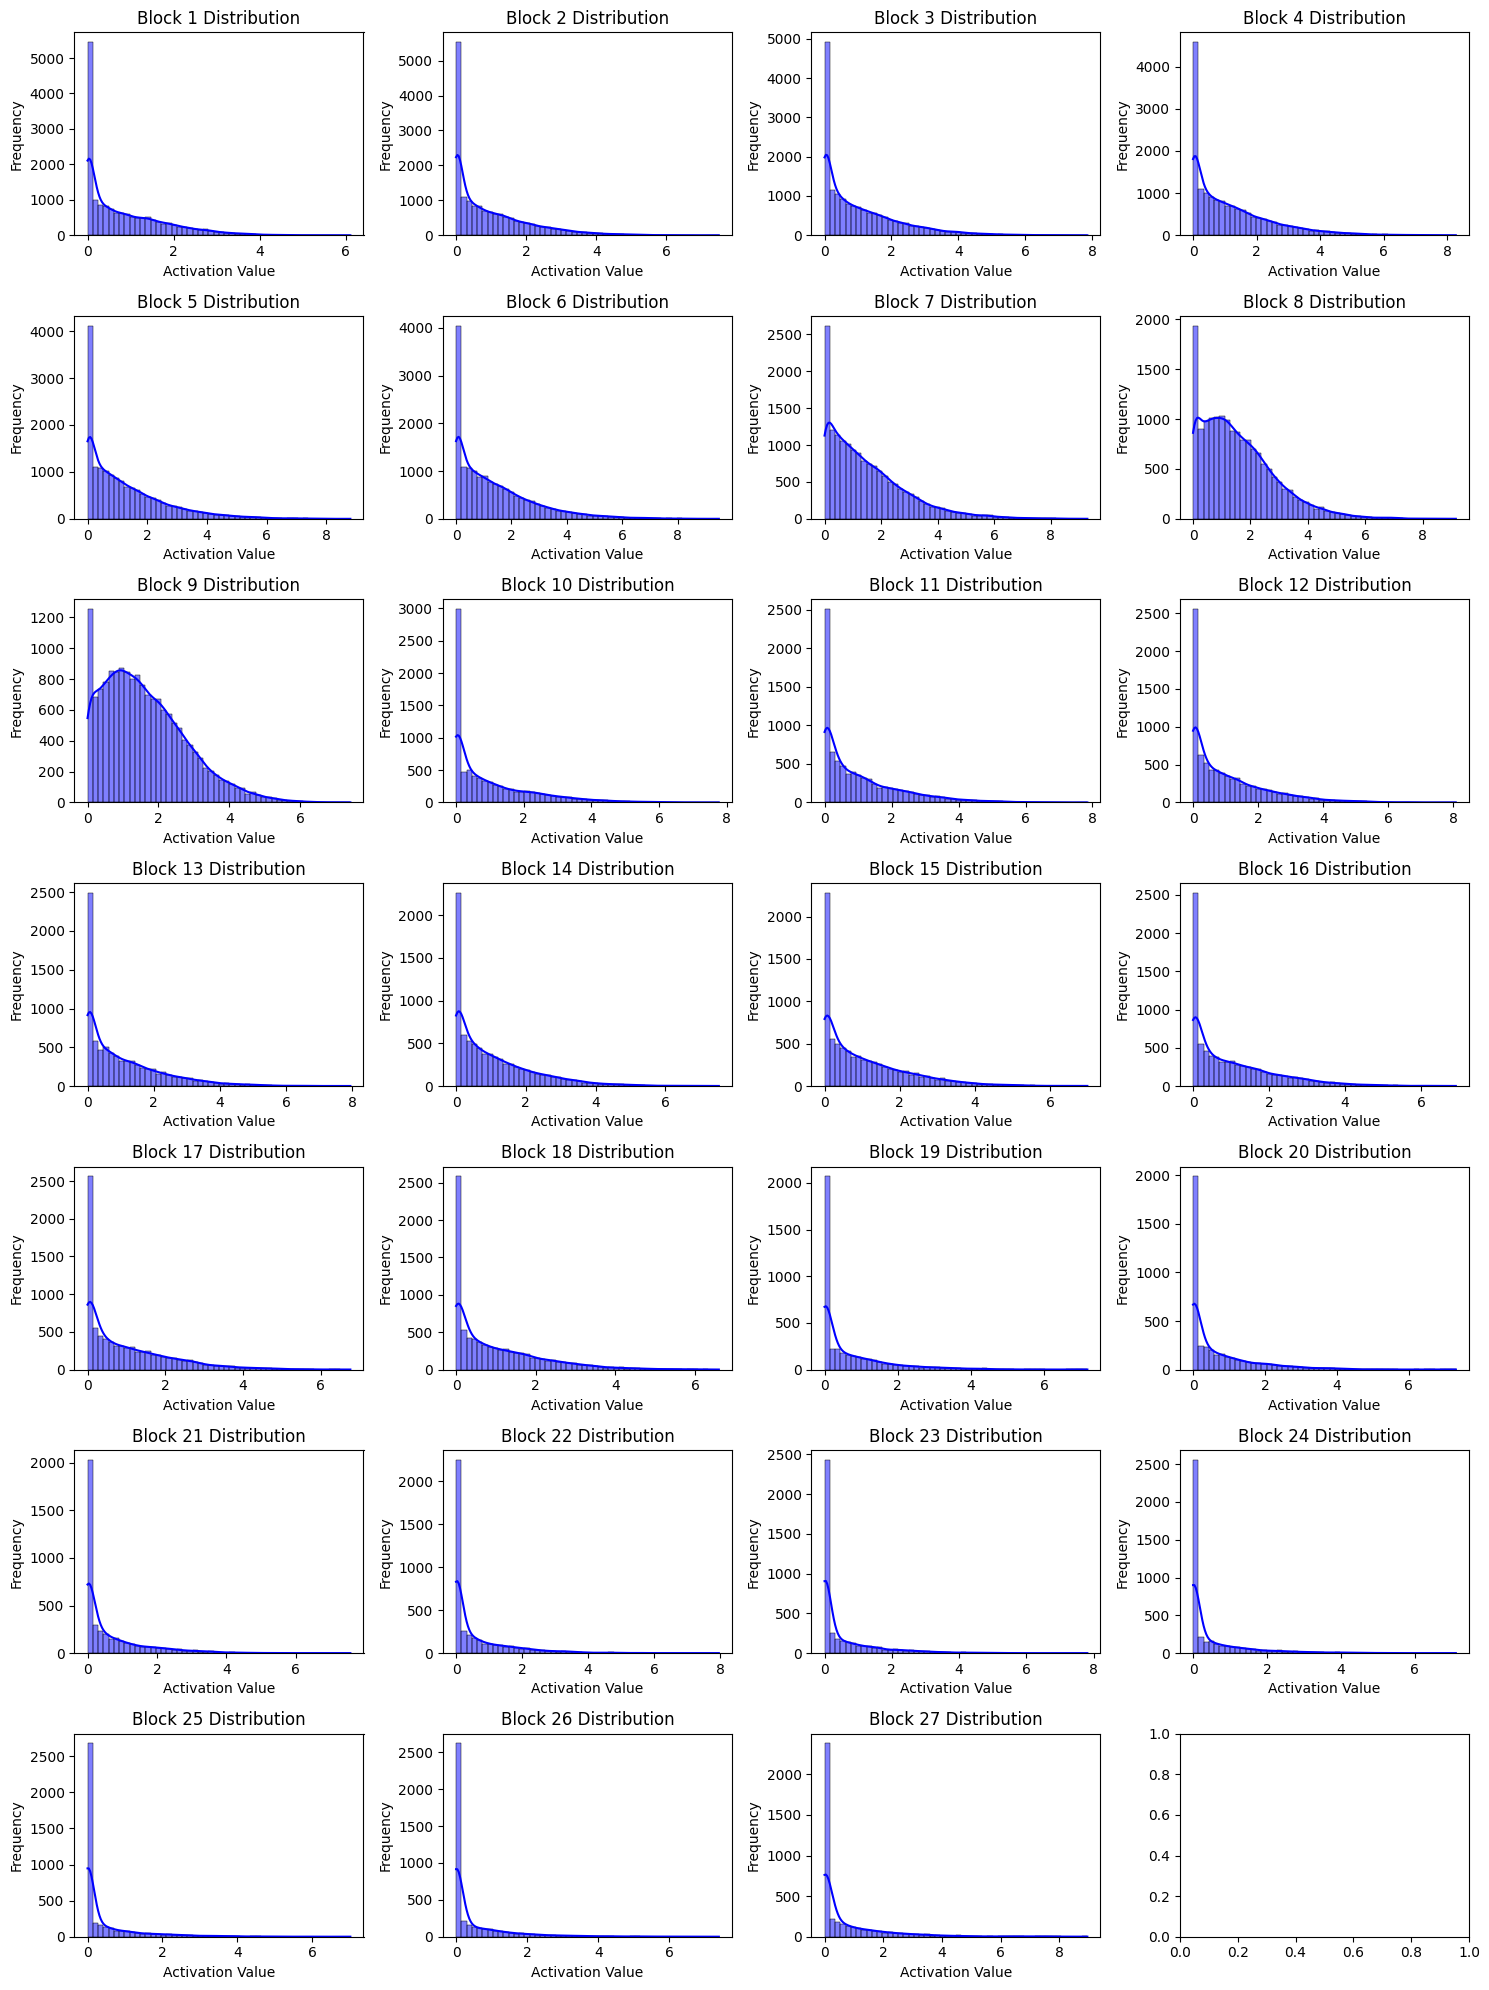

In [3]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torchvision.models as models

import os
import sys
sys.path.append("/ssd5/Roy/pytorch_resnet_cifar10-master")
import resnet_cifar10
arch = "resnet56"
model = resnet_cifar10.__dict__[arch]()
path=os.path.join('/ssd5/Roy/pytorch_resnet_cifar10-master/pretrained_models', arch + '.th')
checkpoint = torch.load(path)
state_dict = checkpoint['state_dict']  # 如果你的檔案裡有 `state_dict`，取出來

# 移除 "module." 前綴
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key.replace("module.", "")  # 移除 module.
    new_state_dict[new_key] = value

# 加載到模型
model.load_state_dict(new_state_dict)



# 用來存儲各層輸出的列表
activations = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn(module, input, output):
    activations.append(output)

# 設置鉤子，將鉤子添加到每個 stage 和 unit
hooks = []

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 遍歷所有 stages 和 units，根據判斷註冊鉤子
for stage_idx, stage in enumerate(model.children()):
    if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
        # print("stage:",stage)
        for unit_idx, unit in enumerate(stage):
            if has_children(unit):
                hook = unit.register_forward_hook(hook_fn)
                hooks.append(hook)
                # print("unit:",unit)

print(len(hooks))

# 隨機生成輸入，形狀為 (1, 3, 224, 224)
input_tensor = torch.randn(1, 3, 32, 32)

# 前向傳遞，這將觸發鉤子
model(input_tensor)

# 繪製每個 block 的數據分佈圖（直方圖）
fig, axes = plt.subplots(7, 4, figsize=(15, 20))  # 設置 8x4 子圖來顯示 32 個直方圖
axes = axes.flatten()

# 遍歷每個 block 的激活並繪製分佈圖
for i in range(min(27, len(activations))):  # 確保最多繪製 32 張圖
    activation = activations[i].cpu().detach().numpy()  # 取得激活並轉換為 numpy 格式
    flattened_activation = activation.flatten()  # 展平為一維數據
    
    # 繪製數據分佈，使用 seaborn 畫出密度圖
    sns.histplot(flattened_activation, kde=True, ax=axes[i], color='blue', bins=50)
    axes[i].set_title(f'Block {i+1} Distribution')
    axes[i].set_xlabel('Activation Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 釋放鉤子
for hook in hooks:
    hook.remove()

In [ ]:
import torch
import numpy as np
import pandas as pd
import torchvision.models as models

import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)  # 保證所有操作可重現
set_seed(5)  # 設定固定種子

# 用來存儲層輸出的列表
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    activations_pretrained.append(output)

# 設置鉤子，將鉤子添加到每個 unit（block）
hooks_pretrained = []

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義一個函數來加載權重並獲取分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 清空之前的激活
    activations_pretrained.clear()

    # 如果有自訓練權重，則加載它們
    if weights:
        checkpoint = torch.load(weights, weights_only=True)
        model.load_state_dict(checkpoint['state_dict'], strict=False)

    # 為每個 block 註冊鉤子
    for stage_idx, stage in enumerate(model.children()):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
            for unit_idx, unit in enumerate(stage):
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)
    print(len(hooks))
    
    # 隨機生成輸入，形狀為 (1, 3, 224, 224)
    input_tensor = torch.randn(1, 3, 32, 32)

    # 前向傳遞，這將觸發鉤子
    model(input_tensor)

    # 釋放鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    import os
    import sys
    sys.path.append("/ssd5/Roy/pytorch_resnet_cifar10-master")
    import resnet_cifar10
    arch = "resnet56"
    model = resnet_cifar10.__dict__[arch]()
    path=os.path.join('/ssd5/Roy/pytorch_resnet_cifar10-master/pretrained_models', arch + '.th')
    checkpoint = torch.load(path)
    state_dict = checkpoint['state_dict']  # 如果你的檔案裡有 `state_dict`，取出來

    # 移除 "module." 前綴
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace("module.", "")  # 移除 module.
        new_state_dict[new_key] = value

    # 加載到模型
    model.load_state_dict(new_state_dict)
    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)  # 預訓練權重

activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

# 統計信息
stats = []

num_plots = min(27, len(activations_pretrained_copy))

for i in range(num_plots):  
    # 取得預訓練激活並轉換為 numpy 格式
    activation_pretrained = activations_pretrained_copy[i].cpu().detach().numpy()
    flattened_activation_pretrained = activation_pretrained.flatten()

    # 計算均值和標準差
    mean_pretrained = np.mean(flattened_activation_pretrained)
    std_pretrained = np.std(flattened_activation_pretrained)

    # 獲取輸出形狀
    output_shape = activation_pretrained.shape

    # 存儲統計信息
    stats.append([i+1, output_shape, mean_pretrained, std_pretrained])

# 創建 DataFrame 並顯示
columns = ['block_index', 'output shape', 'mean of pretrained', 'std of pretrained']
df_stats = pd.DataFrame(stats, columns=columns)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Activation Statistics", dataframe=df_stats)  # 顯示數據表格

display(df_stats.style.hide(axis="index"))



# KS Test

In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "5"

import torch
import numpy as np
import pandas as pd
from pytorchcv.model_provider import get_model as ptcv_get_model
import torchvision.models as models
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu, ks_2samp, ttest_ind, anderson_ksamp, cramervonmises_2samp


import time  # 加在最上面
start_time = time.time()  # 開始時間

import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)  # 保證所有操作可重現
# set_seed(5)  # 設定固定種子

# 設定 device 為 GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# 用來存儲層輸出的列表（轉移到 CPU 以節省 GPU 記憶體）
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    # 將 output detach、clone 並移到 CPU（避免持續佔用 GPU 記憶體）
    activations_pretrained.append(output.detach().clone().cpu())

# 設置鉤子列表
hooks_pretrained = []
hooks_finetuned = []

import torchvision.transforms as T
from PIL import Image
def read_image(path):
    image = Image.open(path).convert('RGB')
    image = T.Compose([
        T.Resize(224 + 224// 8, interpolation=T.InterpolationMode.BILINEAR),
        T.CenterCrop(224),
        T.ToTensor(),
        # T.Normalize(mean=self.norm_mean, std=self.norm_std),
    ])(image)
    return image

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義一個函數來加載權重並獲取激活分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 根據 hook_fn 判斷要清空哪個全域列表
    if hook_fn == hook_fn_pretrained:
        activations_pretrained.clear()
    elif hook_fn == hook_fn_finetuned:
        activations_finetuned.clear()
    
    # 如果有權重檔案，則加載它們
    if weights:
        checkpoint = torch.load(weights, weights_only=True)
        model.load_state_dict(checkpoint['state_dict'], strict=False)
    
    # 為每個 block 註冊鉤子
    for stage_idx, stage in enumerate(model.children()):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
            for unit_idx, unit in enumerate(stage):
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)
    # print(len(hooks))
    
    # 生成輸入 tensor，並將其放到 device 上
    input_tensor = torch.randn(1, 3, 32, 32, device=device)
    # input_tensor = torch.empty(1, 3, 32, 32, device=device).uniform_(-1, 1)

    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Real_youtube/000/000.png'
    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Deepfakes/000_003/000.png'
    # image = read_image(path).to(device)
    # image = image.unsqueeze(0)
    # print(image.shape)
    # model(image)
    model.to(device)
    model(input_tensor)
    
    # 移除所有鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    import os
    import sys
    sys.path.append("/ssd5/Roy/pruning/pytorch_resnet_cifar10-master")
    import resnet_cifar10
    arch = "resnet56"
    model = resnet_cifar10.__dict__[arch]()
    path=os.path.join('/ssd5/Roy/pruning/pytorch_resnet_cifar10-master/pretrained_models', arch + '.th')
    checkpoint = torch.load(path)
    state_dict = checkpoint['state_dict']  # 如果你的檔案裡有 `state_dict`，取出來

    # 移除 "module." 前綴
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace("module.", "")  # 移除 module.
        new_state_dict[new_key] = value

    # 加載到模型
    model.load_state_dict(new_state_dict)
    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

rows = []
n = len(activations_pretrained_copy)
for i in range(1, n):
    # Pretrained 模型
    act_before_pre = activations_pretrained_copy[i-1].numpy().flatten()
    act_after_pre  = activations_pretrained_copy[i].numpy().flatten()

    act_before_pre = remove_outliers(act_before_pre)
    act_after_pre = remove_outliers(act_after_pre)

    # T-test
    _, p_val_t = ttest_ind(act_before_pre, act_after_pre, equal_var=False)

    # Mann–Whitney U
    _, p_val_mw = mannwhitneyu(act_before_pre, act_after_pre, alternative='two-sided')

   # KS
    _, p_val_ks = ks_2samp(act_before_pre, act_after_pre)

    # Cramér–von Mises
    try:
        from scipy.stats import cramervonmises_2samp
        cvm_result = cramervonmises_2samp(act_before_pre, act_after_pre)
        p_val_cvm = cvm_result.pvalue
    except Exception:
        p_val_cvm = np.nan

    # Anderson–Darling
    try:
        ad_result = anderson_ksamp([act_before_pre, act_after_pre])
        p_val_ad = ad_result.significance_level / 100
    except Exception:
        p_val_ad = np.nan

    
    # 紀錄統計資訊
    output_shape = activations_pretrained_copy[i].shape
    mean_val = np.mean(act_after_pre)
    std_val = np.std(act_after_pre)

    
    rows.append([
        i, output_shape, #mean_val, std_val,
        p_val_t, "*" if p_val_t < 0.05 else "",
        p_val_mw, "*" if p_val_mw < 0.05 else "",
        p_val_ks, "*" if p_val_ks < 0.05 else "",
        p_val_cvm, "*" if p_val_cvm < 0.05 else "",
        p_val_ad, "*" if p_val_ad < 0.05 else "",
    ])


# 建立 DataFrame
columns = [
    'block_index', 'output shape', #'mean of pretrained', 'std of pretrained',
    'p_val_t', 'sig_t',
    'p_val_mw', 'sig_mw',
    'p_val_ks', 'sig_ks',
    'p_val_cvm', 'sig_cvm',
    'p_val_ad', 'sig_ad',
]
df_stats = pd.DataFrame(rows, columns=columns)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal elapsed time: {elapsed_time:.2f} seconds")

display(df_stats.style.hide(axis="index"))



/tmp/ipykernel_2140309/3279447078.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)
/tmp/ipykernel_2140309/3279447078.py:167: UserWarning: 


Total elapsed time: 1.47 seconds


block_index,output shape,p_val_t,sig_t,p_val_mw,sig_mw,p_val_ks,sig_ks,p_val_cvm,sig_cvm,p_val_ad,sig_ad
1,"torch.Size([1, 16, 32, 32])",0.000000,*,0.000211,*,0.000000,*,0.000004,*,0.000010,*
2,"torch.Size([1, 16, 32, 32])",0.000000,*,0.000000,*,0.000000,*,0.000000,*,0.000010,*
3,"torch.Size([1, 16, 32, 32])",0.000000,*,0.000000,*,0.000000,*,0.000000,*,0.000010,*
4,"torch.Size([1, 16, 32, 32])",0.000000,*,0.000000,*,0.000000,*,0.000000,*,0.000010,*
5,"torch.Size([1, 16, 32, 32])",0.000000,*,0.000000,*,0.000000,*,0.000000,*,0.000010,*
6,"torch.Size([1, 16, 32, 32])",0.000000,*,0.000000,*,0.000000,*,0.000000,*,0.000010,*
7,"torch.Size([1, 16, 32, 32])",0.000000,*,0.000000,*,0.000000,*,0.000000,*,0.000010,*
8,"torch.Size([1, 16, 32, 32])",0.000000,*,0.000000,*,0.000000,*,0.000000,*,0.000010,*
9,"torch.Size([1, 32, 16, 16])",0.000000,*,0.000000,*,0.000000,*,0.000000,*,0.000010,*
10,"torch.Size([1, 32, 16, 16])",0.019491,*,0.000000,*,0.000000,*,0.000000,*,0.000010,*


In [ ]:
# 估計檢定力的參數
B = 1000  # random tensor 次數
n_blocks = len(activations_pretrained_copy)  # 假設與 forward 後的 block 數一致

# 初始化記錄每次是否拒絕 H0（每個檢定方法都有一份字典）
results_dict = {
    't': {i: [] for i in range(1, n_blocks)},
    'mw': {i: [] for i in range(1, n_blocks)},
    'ks': {i: [] for i in range(1, n_blocks)},
    'cvm': {i: [] for i in range(1, n_blocks)},
    'ad': {i: [] for i in range(1, n_blocks)},
}

for b in range(B):
    # 每次都重新 forward 一個新的 random tensor
    get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
    acts = activations_pretrained.copy()

    for i in range(1, n_blocks):
        a = remove_outliers(acts[i-1].numpy().flatten())
        b = remove_outliers(acts[i].numpy().flatten())

        try:
            _, p_t = ttest_ind(a, b, equal_var=False)
        except:
            p_t = 1.0
        results_dict['t'][i].append(p_t < 0.05)

        try:
            _, p_mw = mannwhitneyu(a, b, alternative='two-sided')
        except:
            p_mw = 1.0
        results_dict['mw'][i].append(p_mw < 0.05)

        try:
            _, p_ks = ks_2samp(a, b)
        except:
            p_ks = 1.0
        results_dict['ks'][i].append(p_ks < 0.05)

        try:
            p_cvm = cramervonmises_2samp(a, b).pvalue
        except:
            p_cvm = 1.0
        results_dict['cvm'][i].append(p_cvm < 0.05)

        try:
            p_ad = anderson_ksamp([a, b]).significance_level / 100
        except:
            p_ad = 1.0
        results_dict['ad'][i].append(p_ad < 0.05)

# 最終輸出為估計檢定力表格
rows = []
for i in range(1, n_blocks):
    rows.append([
        i,
        np.mean(results_dict['t'][i]),
        np.mean(results_dict['mw'][i]),
        np.mean(results_dict['ks'][i]),
        np.mean(results_dict['cvm'][i]),
        np.mean(results_dict['ad'][i]),
    ])

df_power = pd.DataFrame(rows, columns=[
    'block_index',
    'power_t', 'power_mw', 'power_ks', 'power_cvm', 'power_ad'
])
# print(df_power)
# df_power.to_csv("blockwise_empirical_power.csv", index=False)
df_power


/tmp/ipykernel_172973/1036286894.py:48: UserWarning: p-value floored: true value smaller than 0.001
  p_ad = anderson_ksamp([a, b]).significance_level / 100
/tmp/ipykernel_172973/1036286894.py:48: UserWarning: p-value capped: true value larger than 0.25
  p_ad = anderson_ksamp([a, b]).significance_level / 100


,block_index,power_t,power_mw,power_ks,power_cvm,power_ad
0,1,1.000,1.000,1.000,1.000,1.0
1,2,1.000,1.000,1.000,1.000,1.0
2,3,1.000,1.000,1.000,1.000,1.0
3,4,1.000,1.000,1.000,1.000,1.0
4,5,1.000,1.000,1.000,1.000,1.0
5,6,1.000,1.000,1.000,1.000,1.0
6,7,1.000,1.000,1.000,1.000,1.0
7,8,1.000,1.000,1.000,1.000,1.0
8,9,1.000,1.000,1.000,1.000,1.0
9,10,0.996,1.000,1.000,1.000,1.0


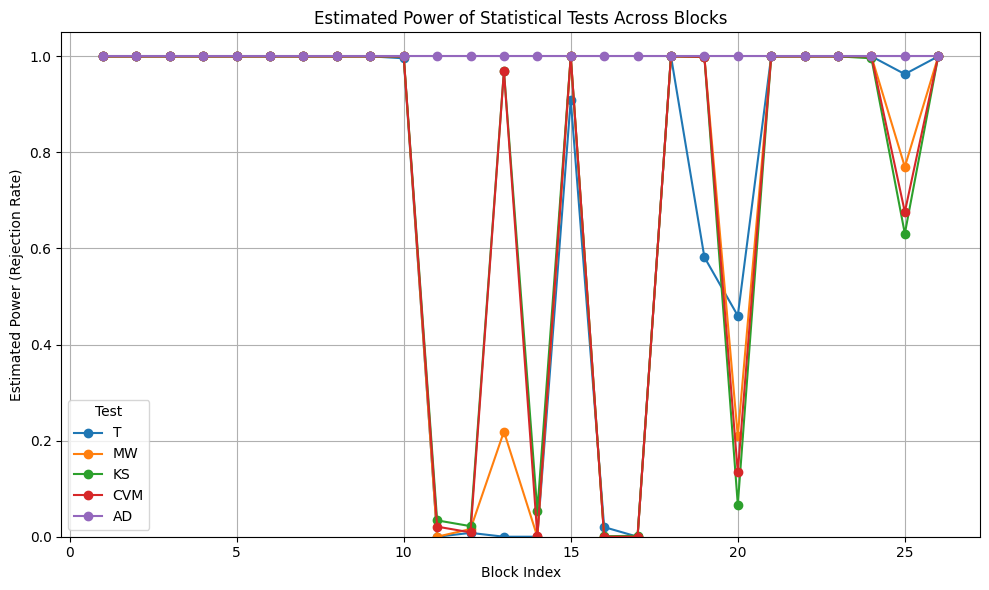

In [5]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(10, 6))
for method in ['power_t', 'power_mw', 'power_ks', 'power_cvm', 'power_ad']:
    plt.plot(df_power['block_index'], df_power[method], marker='o', label=method.replace("power_", "").upper())

plt.title("Estimated Power of Statistical Tests Across Blocks")
plt.xlabel("Block Index")
plt.ylabel("Estimated Power (Rejection Rate)")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend(title="Test")
plt.tight_layout()
plt.show()

# ALPHA 調整看看

In [3]:
alpha = 0.5
# 估計檢定力的參數
B = 100  # random tensor 次數
n_blocks = len(activations_pretrained_copy)  # 假設與 forward 後的 block 數一致

# 初始化記錄每次是否拒絕 H0（每個檢定方法都有一份字典）
results_dict = {
    't': {i: [] for i in range(1, n_blocks)},
    'mw': {i: [] for i in range(1, n_blocks)},
    'ks': {i: [] for i in range(1, n_blocks)},
    'cvm': {i: [] for i in range(1, n_blocks)},
    'ad': {i: [] for i in range(1, n_blocks)},
}

for b in range(B):
    # 每次都重新 forward 一個新的 random tensor
    get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
    acts = activations_pretrained.copy()

    for i in range(1, n_blocks):
        a = remove_outliers(acts[i-1].numpy().flatten())
        b = remove_outliers(acts[i].numpy().flatten())

        try:
            _, p_t = ttest_ind(a, b, equal_var=False)
        except:
            p_t = 1.0
        results_dict['t'][i].append(p_t < alpha)

        try:
            _, p_mw = mannwhitneyu(a, b, alternative='two-sided')
        except:
            p_mw = 1.0
        results_dict['mw'][i].append(p_mw < alpha)

        try:
            _, p_ks = ks_2samp(a, b)
        except:
            p_ks = 1.0
        results_dict['ks'][i].append(p_ks < alpha)

        try:
            p_cvm = cramervonmises_2samp(a, b).pvalue
        except:
            p_cvm = 1.0
        results_dict['cvm'][i].append(p_cvm < alpha)

        try:
            p_ad = anderson_ksamp([a, b]).significance_level / 100
        except:
            p_ad = 1.0
        results_dict['ad'][i].append(p_ad < alpha)

# 最終輸出為估計檢定力表格
rows = []
for i in range(1, n_blocks):
    rows.append([
        i,
        np.mean(results_dict['t'][i]),
        np.mean(results_dict['mw'][i]),
        np.mean(results_dict['ks'][i]),
        np.mean(results_dict['cvm'][i]),
        np.mean(results_dict['ad'][i]),
    ])

df_power = pd.DataFrame(rows, columns=[
    'block_index',
    'power_t', 'power_mw', 'power_ks', 'power_cvm', 'power_ad'
])
# print(df_power)
# df_power.to_csv("blockwise_empirical_power.csv", index=False)
df_power


/tmp/ipykernel_370381/424167433.py:49: UserWarning: p-value floored: true value smaller than 0.001
  p_ad = anderson_ksamp([a, b]).significance_level / 100
/tmp/ipykernel_370381/424167433.py:49: UserWarning: p-value capped: true value larger than 0.25
  p_ad = anderson_ksamp([a, b]).significance_level / 100


,block_index,power_t,power_mw,power_ks,power_cvm,power_ad
0,1,1.00,1.00,1.00,1.00,1.0
1,2,1.00,1.00,1.00,1.00,1.0
2,3,1.00,1.00,1.00,1.00,1.0
3,4,1.00,1.00,1.00,1.00,1.0
4,5,1.00,1.00,1.00,1.00,1.0
5,6,1.00,1.00,1.00,1.00,1.0
6,7,1.00,1.00,1.00,1.00,1.0
7,8,1.00,1.00,1.00,1.00,1.0
8,9,1.00,1.00,1.00,1.00,1.0
9,10,1.00,1.00,1.00,1.00,1.0


In [6]:
alpha = 0.15
# 估計檢定力的參數
B = 100  # random tensor 次數
n_blocks = len(activations_pretrained_copy)  # 假設與 forward 後的 block 數一致

# 初始化記錄每次是否拒絕 H0（每個檢定方法都有一份字典）
results_dict = {
    't': {i: [] for i in range(1, n_blocks)},
    'mw': {i: [] for i in range(1, n_blocks)},
    'ks': {i: [] for i in range(1, n_blocks)},
    'cvm': {i: [] for i in range(1, n_blocks)},
    'ad': {i: [] for i in range(1, n_blocks)},
}

for b in range(B):
    # 每次都重新 forward 一個新的 random tensor
    get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
    acts = activations_pretrained.copy()

    for i in range(1, n_blocks):
        a = remove_outliers(acts[i-1].numpy().flatten())
        b = remove_outliers(acts[i].numpy().flatten())

        try:
            _, p_t = ttest_ind(a, b, equal_var=False)
        except:
            p_t = 1.0
        results_dict['t'][i].append(p_t < alpha)

        try:
            _, p_mw = mannwhitneyu(a, b, alternative='two-sided')
        except:
            p_mw = 1.0
        results_dict['mw'][i].append(p_mw < alpha)

        try:
            _, p_ks = ks_2samp(a, b)
        except:
            p_ks = 1.0
        results_dict['ks'][i].append(p_ks < alpha)

        try:
            p_cvm = cramervonmises_2samp(a, b).pvalue
        except:
            p_cvm = 1.0
        results_dict['cvm'][i].append(p_cvm < alpha)

        try:
            p_ad = anderson_ksamp([a, b]).significance_level / 100
        except:
            p_ad = 1.0
        results_dict['ad'][i].append(p_ad < alpha)

# 最終輸出為估計檢定力表格
rows = []
for i in range(1, n_blocks):
    rows.append([
        i,
        np.mean(results_dict['t'][i]),
        np.mean(results_dict['mw'][i]),
        np.mean(results_dict['ks'][i]),
        np.mean(results_dict['cvm'][i]),
        np.mean(results_dict['ad'][i]),
    ])

df_power = pd.DataFrame(rows, columns=[
    'block_index',
    'power_t', 'power_mw', 'power_ks', 'power_cvm', 'power_ad'
])
# print(df_power)
# df_power.to_csv("blockwise_empirical_power.csv", index=False)
df_power


/tmp/ipykernel_172973/2390576133.py:49: UserWarning: p-value floored: true value smaller than 0.001
  p_ad = anderson_ksamp([a, b]).significance_level / 100
/tmp/ipykernel_172973/2390576133.py:49: UserWarning: p-value capped: true value larger than 0.25
  p_ad = anderson_ksamp([a, b]).significance_level / 100


,block_index,power_t,power_mw,power_ks,power_cvm,power_ad
0,1,1.00,1.00,1.00,1.00,1.0
1,2,1.00,1.00,1.00,1.00,1.0
2,3,1.00,1.00,1.00,1.00,1.0
3,4,1.00,1.00,1.00,1.00,1.0
4,5,1.00,1.00,1.00,1.00,1.0
5,6,1.00,1.00,1.00,1.00,1.0
6,7,1.00,1.00,1.00,1.00,1.0
7,8,1.00,1.00,1.00,1.00,1.0
8,9,1.00,1.00,1.00,1.00,1.0
9,10,1.00,1.00,1.00,1.00,1.0


In [7]:
alpha = 0.10
# 估計檢定力的參數
B = 100  # random tensor 次數
n_blocks = len(activations_pretrained_copy)  # 假設與 forward 後的 block 數一致

# 初始化記錄每次是否拒絕 H0（每個檢定方法都有一份字典）
results_dict = {
    't': {i: [] for i in range(1, n_blocks)},
    'mw': {i: [] for i in range(1, n_blocks)},
    'ks': {i: [] for i in range(1, n_blocks)},
    'cvm': {i: [] for i in range(1, n_blocks)},
    'ad': {i: [] for i in range(1, n_blocks)},
}

for b in range(B):
    # 每次都重新 forward 一個新的 random tensor
    get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
    acts = activations_pretrained.copy()

    for i in range(1, n_blocks):
        a = remove_outliers(acts[i-1].numpy().flatten())
        b = remove_outliers(acts[i].numpy().flatten())

        try:
            _, p_t = ttest_ind(a, b, equal_var=False)
        except:
            p_t = 1.0
        results_dict['t'][i].append(p_t < alpha)

        try:
            _, p_mw = mannwhitneyu(a, b, alternative='two-sided')
        except:
            p_mw = 1.0
        results_dict['mw'][i].append(p_mw < alpha)

        try:
            _, p_ks = ks_2samp(a, b)
        except:
            p_ks = 1.0
        results_dict['ks'][i].append(p_ks < alpha)

        try:
            p_cvm = cramervonmises_2samp(a, b).pvalue
        except:
            p_cvm = 1.0
        results_dict['cvm'][i].append(p_cvm < alpha)

        try:
            p_ad = anderson_ksamp([a, b]).significance_level / 100
        except:
            p_ad = 1.0
        results_dict['ad'][i].append(p_ad < alpha)

# 最終輸出為估計檢定力表格
rows = []
for i in range(1, n_blocks):
    rows.append([
        i,
        np.mean(results_dict['t'][i]),
        np.mean(results_dict['mw'][i]),
        np.mean(results_dict['ks'][i]),
        np.mean(results_dict['cvm'][i]),
        np.mean(results_dict['ad'][i]),
    ])

df_power = pd.DataFrame(rows, columns=[
    'block_index',
    'power_t', 'power_mw', 'power_ks', 'power_cvm', 'power_ad'
])
# print(df_power)
# df_power.to_csv("blockwise_empirical_power.csv", index=False)
df_power


/tmp/ipykernel_172973/1899511584.py:49: UserWarning: p-value floored: true value smaller than 0.001
  p_ad = anderson_ksamp([a, b]).significance_level / 100
/tmp/ipykernel_172973/1899511584.py:49: UserWarning: p-value capped: true value larger than 0.25
  p_ad = anderson_ksamp([a, b]).significance_level / 100


,block_index,power_t,power_mw,power_ks,power_cvm,power_ad
0,1,1.00,1.00,1.00,1.00,1.0
1,2,1.00,1.00,1.00,1.00,1.0
2,3,1.00,1.00,1.00,1.00,1.0
3,4,1.00,1.00,1.00,1.00,1.0
4,5,1.00,1.00,1.00,1.00,1.0
5,6,1.00,1.00,1.00,1.00,1.0
6,7,1.00,1.00,1.00,1.00,1.0
7,8,1.00,1.00,1.00,1.00,1.0
8,9,1.00,1.00,1.00,1.00,1.0
9,10,1.00,1.00,1.00,1.00,1.0


In [8]:
alpha = 0.05
# 估計檢定力的參數
B = 100  # random tensor 次數
n_blocks = len(activations_pretrained_copy)  # 假設與 forward 後的 block 數一致

# 初始化記錄每次是否拒絕 H0（每個檢定方法都有一份字典）
results_dict = {
    't': {i: [] for i in range(1, n_blocks)},
    'mw': {i: [] for i in range(1, n_blocks)},
    'ks': {i: [] for i in range(1, n_blocks)},
    'cvm': {i: [] for i in range(1, n_blocks)},
    'ad': {i: [] for i in range(1, n_blocks)},
}

for b in range(B):
    # 每次都重新 forward 一個新的 random tensor
    get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
    acts = activations_pretrained.copy()

    for i in range(1, n_blocks):
        a = remove_outliers(acts[i-1].numpy().flatten())
        b = remove_outliers(acts[i].numpy().flatten())

        try:
            _, p_t = ttest_ind(a, b, equal_var=False)
        except:
            p_t = 1.0
        results_dict['t'][i].append(p_t < alpha)

        try:
            _, p_mw = mannwhitneyu(a, b, alternative='two-sided')
        except:
            p_mw = 1.0
        results_dict['mw'][i].append(p_mw < alpha)

        try:
            _, p_ks = ks_2samp(a, b)
        except:
            p_ks = 1.0
        results_dict['ks'][i].append(p_ks < alpha)

        try:
            p_cvm = cramervonmises_2samp(a, b).pvalue
        except:
            p_cvm = 1.0
        results_dict['cvm'][i].append(p_cvm < alpha)

        try:
            p_ad = anderson_ksamp([a, b]).significance_level / 100
        except:
            p_ad = 1.0
        results_dict['ad'][i].append(p_ad < alpha)

# 最終輸出為估計檢定力表格
rows = []
for i in range(1, n_blocks):
    rows.append([
        i,
        np.mean(results_dict['t'][i]),
        np.mean(results_dict['mw'][i]),
        np.mean(results_dict['ks'][i]),
        np.mean(results_dict['cvm'][i]),
        np.mean(results_dict['ad'][i]),
    ])

df_power = pd.DataFrame(rows, columns=[
    'block_index',
    'power_t', 'power_mw', 'power_ks', 'power_cvm', 'power_ad'
])
# print(df_power)
# df_power.to_csv("blockwise_empirical_power.csv", index=False)
df_power


/tmp/ipykernel_172973/3222762996.py:49: UserWarning: p-value floored: true value smaller than 0.001
  p_ad = anderson_ksamp([a, b]).significance_level / 100
/tmp/ipykernel_172973/3222762996.py:49: UserWarning: p-value capped: true value larger than 0.25
  p_ad = anderson_ksamp([a, b]).significance_level / 100


,block_index,power_t,power_mw,power_ks,power_cvm,power_ad
0,1,1.00,1.00,1.00,1.00,1.0
1,2,1.00,1.00,1.00,1.00,1.0
2,3,1.00,1.00,1.00,1.00,1.0
3,4,1.00,1.00,1.00,1.00,1.0
4,5,1.00,1.00,1.00,1.00,1.0
5,6,1.00,1.00,1.00,1.00,1.0
6,7,1.00,1.00,1.00,1.00,1.0
7,8,1.00,1.00,1.00,1.00,1.0
8,9,1.00,1.00,1.00,1.00,1.0
9,10,1.00,1.00,1.00,1.00,1.0


In [9]:
alpha = 0.01
# 估計檢定力的參數
B = 100  # random tensor 次數
n_blocks = len(activations_pretrained_copy)  # 假設與 forward 後的 block 數一致

# 初始化記錄每次是否拒絕 H0（每個檢定方法都有一份字典）
results_dict = {
    't': {i: [] for i in range(1, n_blocks)},
    'mw': {i: [] for i in range(1, n_blocks)},
    'ks': {i: [] for i in range(1, n_blocks)},
    'cvm': {i: [] for i in range(1, n_blocks)},
    'ad': {i: [] for i in range(1, n_blocks)},
}

for b in range(B):
    # 每次都重新 forward 一個新的 random tensor
    get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
    acts = activations_pretrained.copy()

    for i in range(1, n_blocks):
        a = remove_outliers(acts[i-1].numpy().flatten())
        b = remove_outliers(acts[i].numpy().flatten())

        try:
            _, p_t = ttest_ind(a, b, equal_var=False)
        except:
            p_t = 1.0
        results_dict['t'][i].append(p_t < alpha)

        try:
            _, p_mw = mannwhitneyu(a, b, alternative='two-sided')
        except:
            p_mw = 1.0
        results_dict['mw'][i].append(p_mw < alpha)

        try:
            _, p_ks = ks_2samp(a, b)
        except:
            p_ks = 1.0
        results_dict['ks'][i].append(p_ks < alpha)

        try:
            p_cvm = cramervonmises_2samp(a, b).pvalue
        except:
            p_cvm = 1.0
        results_dict['cvm'][i].append(p_cvm < alpha)

        try:
            p_ad = anderson_ksamp([a, b]).significance_level / 100
        except:
            p_ad = 1.0
        results_dict['ad'][i].append(p_ad < alpha)

# 最終輸出為估計檢定力表格
rows = []
for i in range(1, n_blocks):
    rows.append([
        i,
        np.mean(results_dict['t'][i]),
        np.mean(results_dict['mw'][i]),
        np.mean(results_dict['ks'][i]),
        np.mean(results_dict['cvm'][i]),
        np.mean(results_dict['ad'][i]),
    ])

df_power = pd.DataFrame(rows, columns=[
    'block_index',
    'power_t', 'power_mw', 'power_ks', 'power_cvm', 'power_ad'
])
# print(df_power)
# df_power.to_csv("blockwise_empirical_power.csv", index=False)
df_power


/tmp/ipykernel_172973/3233044951.py:49: UserWarning: p-value floored: true value smaller than 0.001
  p_ad = anderson_ksamp([a, b]).significance_level / 100
/tmp/ipykernel_172973/3233044951.py:49: UserWarning: p-value capped: true value larger than 0.25
  p_ad = anderson_ksamp([a, b]).significance_level / 100


,block_index,power_t,power_mw,power_ks,power_cvm,power_ad
0,1,1.00,1.00,1.00,1.00,1.0
1,2,1.00,1.00,1.00,1.00,1.0
2,3,1.00,1.00,1.00,1.00,1.0
3,4,1.00,1.00,1.00,1.00,1.0
4,5,1.00,1.00,1.00,1.00,1.0
5,6,1.00,1.00,1.00,1.00,1.0
6,7,1.00,1.00,1.00,1.00,1.0
7,8,1.00,1.00,1.00,1.00,1.0
8,9,1.00,1.00,1.00,1.00,1.0
9,10,0.64,1.00,1.00,1.00,1.0


In [10]:
alpha = 0.005
# 估計檢定力的參數
B = 100  # random tensor 次數
n_blocks = len(activations_pretrained_copy)  # 假設與 forward 後的 block 數一致

# 初始化記錄每次是否拒絕 H0（每個檢定方法都有一份字典）
results_dict = {
    't': {i: [] for i in range(1, n_blocks)},
    'mw': {i: [] for i in range(1, n_blocks)},
    'ks': {i: [] for i in range(1, n_blocks)},
    'cvm': {i: [] for i in range(1, n_blocks)},
    'ad': {i: [] for i in range(1, n_blocks)},
}

for b in range(B):
    # 每次都重新 forward 一個新的 random tensor
    get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
    acts = activations_pretrained.copy()

    for i in range(1, n_blocks):
        a = remove_outliers(acts[i-1].numpy().flatten())
        b = remove_outliers(acts[i].numpy().flatten())

        try:
            _, p_t = ttest_ind(a, b, equal_var=False)
        except:
            p_t = 1.0
        results_dict['t'][i].append(p_t < alpha)

        try:
            _, p_mw = mannwhitneyu(a, b, alternative='two-sided')
        except:
            p_mw = 1.0
        results_dict['mw'][i].append(p_mw < alpha)

        try:
            _, p_ks = ks_2samp(a, b)
        except:
            p_ks = 1.0
        results_dict['ks'][i].append(p_ks < alpha)

        try:
            p_cvm = cramervonmises_2samp(a, b).pvalue
        except:
            p_cvm = 1.0
        results_dict['cvm'][i].append(p_cvm < alpha)

        try:
            p_ad = anderson_ksamp([a, b]).significance_level / 100
        except:
            p_ad = 1.0
        results_dict['ad'][i].append(p_ad < alpha)

# 最終輸出為估計檢定力表格
rows = []
for i in range(1, n_blocks):
    rows.append([
        i,
        np.mean(results_dict['t'][i]),
        np.mean(results_dict['mw'][i]),
        np.mean(results_dict['ks'][i]),
        np.mean(results_dict['cvm'][i]),
        np.mean(results_dict['ad'][i]),
    ])

df_power = pd.DataFrame(rows, columns=[
    'block_index',
    'power_t', 'power_mw', 'power_ks', 'power_cvm', 'power_ad'
])
# print(df_power)
# df_power.to_csv("blockwise_empirical_power.csv", index=False)
df_power


/tmp/ipykernel_172973/1481956495.py:49: UserWarning: p-value floored: true value smaller than 0.001
  p_ad = anderson_ksamp([a, b]).significance_level / 100
/tmp/ipykernel_172973/1481956495.py:49: UserWarning: p-value capped: true value larger than 0.25
  p_ad = anderson_ksamp([a, b]).significance_level / 100


,block_index,power_t,power_mw,power_ks,power_cvm,power_ad
0,1,1.00,1.00,1.00,1.00,1.0
1,2,1.00,1.00,1.00,1.00,1.0
2,3,1.00,1.00,1.00,1.00,1.0
3,4,1.00,1.00,1.00,1.00,1.0
4,5,1.00,1.00,1.00,1.00,1.0
5,6,1.00,1.00,1.00,1.00,1.0
6,7,1.00,1.00,1.00,1.00,1.0
7,8,1.00,1.00,1.00,1.00,1.0
8,9,1.00,1.00,1.00,1.00,1.0
9,10,0.37,1.00,1.00,1.00,1.0


# 已知H0或H1下檢定(1,1),(2,2),...,(L,L)

In [11]:
import torch
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp, cramervonmises_2samp, anderson_ksamp
from tqdm import tqdm
import pandas as pd

# ========== 設定環境 ==========
torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cpu")

# ========== 載入 ResNet56 模型 ==========
import os
import sys
sys.path.append("/ssd5/Roy/pruning/pytorch_resnet_cifar10-master")
import resnet_cifar10

arch = "resnet56"
model = resnet_cifar10.__dict__[arch]()
path = os.path.join('/ssd5/Roy/pruning/pytorch_resnet_cifar10-master/pretrained_models', arch + '.th')
checkpoint = torch.load(path)
state_dict = checkpoint['state_dict']
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
model.to(device)
model.eval()

# ========== 註冊 Hook ==========
activations = []

def get_hook(i):
    def hook_fn(module, input, output):
        activations[i] = output.detach().cpu().numpy()
    return hook_fn

hooks = []
for i, (name, module) in enumerate(model.named_modules()):
    if isinstance(module, torch.nn.Sequential): continue
    hooks.append(module.register_forward_hook(get_hook(i)))
    activations.append(None)

all_blocks = [m for m in model.modules() if not isinstance(m, torch.nn.Sequential) and not list(m.children())]
n_blocks = len(all_blocks)

# ========== 模擬參數 ==========
B = 100
alpha = 0.05

results_dict = {
    't': {i: [] for i in range(1, n_blocks)},
    'mw': {i: [] for i in range(1, n_blocks)},
    'ks': {i: [] for i in range(1, n_blocks)},
    'cvm': {i: [] for i in range(1, n_blocks)},
    'ad': {i: [] for i in range(1, n_blocks)},
}

# ========== 模擬 Type I Error ==========
for b in tqdm(range(B), desc="Estimating Type I Error"):
    x = torch.randn(1, 3, 32, 32, device=device)
    y = torch.randn(1, 3, 32, 32, device=device)
    _ = model(x)
    acts_x = [a.copy() for a in activations]
    _ = model(y)
    acts_y = [a.copy() for a in activations]

    for i in range(1, n_blocks):
        a = acts_x[i].flatten()
        b = acts_y[i].flatten()
        results_dict['t'][i].append(ttest_ind(a, b, equal_var=False).pvalue < alpha)
        results_dict['mw'][i].append(mannwhitneyu(a, b, alternative='two-sided').pvalue < alpha)
        results_dict['ks'][i].append(ks_2samp(a, b).pvalue < alpha)
        try:
            results_dict['cvm'][i].append(cramervonmises_2samp(a, b).pvalue < alpha)
        except:
            results_dict['cvm'][i].append(False)
        try:
            ad_result = anderson_ksamp([a, b])
            results_dict['ad'][i].append((ad_result.significance_level / 100) < alpha)
        except:
            results_dict['ad'][i].append(False)

# ========== 模擬 Power ==========
for b in tqdm(range(B), desc="Estimating Power"):
    x = torch.randn(1, 3, 32, 32, device=device)
    y = torch.randn(1, 3, 32, 32, device=device) + 0.5  # 不同分佈
    _ = model(x)
    acts_x = [a.copy() for a in activations]
    _ = model(y)
    acts_y = [a.copy() for a in activations]

    for i in range(1, n_blocks):
        a = acts_x[i].flatten()
        b = acts_y[i].flatten()
        results_dict['t'][i].append(ttest_ind(a, b, equal_var=False).pvalue < alpha)
        results_dict['mw'][i].append(mannwhitneyu(a, b, alternative='two-sided').pvalue < alpha)
        results_dict['ks'][i].append(ks_2samp(a, b).pvalue < alpha)
        try:
            results_dict['cvm'][i].append(cramervonmises_2samp(a, b).pvalue < alpha)
        except:
            results_dict['cvm'][i].append(False)
        try:
            ad_result = anderson_ksamp([a, b])
            results_dict['ad'][i].append((ad_result.significance_level / 100) < alpha)
        except:
            results_dict['ad'][i].append(False)

# ========== 統計結果 ==========
rows = []
for i in range(1, n_blocks):
    row = [i]
    for test in ['t', 'mw', 'ks', 'cvm', 'ad']:
        values = results_dict[test][i]
        type1 = np.mean(values[:B])
        power = np.mean(values[B:])
        row.extend([type1, power])
    rows.append(row)

columns = ['block'] + [f'{test}_{metric}' for test in ['t', 'mw', 'ks', 'cvm', 'ad'] for metric in ['type1', 'power']]
df_all = pd.DataFrame(rows, columns=columns)

# Optional: print or save
df_all
# df_all.to_csv("power_type1_all_tests.csv", index=False)


Estimating Type I Error:   0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: Numpy is not available

# 二次計算

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "5"

import torch
import numpy as np
import pandas as pd
from pytorchcv.model_provider import get_model as ptcv_get_model
import torchvision.models as models
from scipy.stats import ttest_ind

import time  # 加在最上面
start_time = time.time()  # 開始時間

import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)  # 保證所有操作可重現
# set_seed(5)  # 設定固定種子

# 設定 device 為 GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# 用來存儲層輸出的列表（轉移到 CPU 以節省 GPU 記憶體）
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    # 將 output detach、clone 並移到 CPU（避免持續佔用 GPU 記憶體）
    activations_pretrained.append(output.detach().clone().cpu())

# 設置鉤子列表
hooks_pretrained = []
hooks_finetuned = []

import torchvision.transforms as T
from PIL import Image
def read_image(path):
    image = Image.open(path).convert('RGB')
    image = T.Compose([
        T.Resize(224 + 224// 8, interpolation=T.InterpolationMode.BILINEAR),
        T.CenterCrop(224),
        T.ToTensor(),
        # T.Normalize(mean=self.norm_mean, std=self.norm_std),
    ])(image)
    return image

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義一個函數來加載權重並獲取激活分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 根據 hook_fn 判斷要清空哪個全域列表
    if hook_fn == hook_fn_pretrained:
        activations_pretrained.clear()
    elif hook_fn == hook_fn_finetuned:
        activations_finetuned.clear()
    
    # 如果有權重檔案，則加載它們
    if weights:
        checkpoint = torch.load(weights, weights_only=True)
        model.load_state_dict(checkpoint['state_dict'], strict=False)
    
    # 為每個 block 註冊鉤子
    for stage_idx, stage in enumerate(model.children()):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
            for unit_idx, unit in enumerate(stage):
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)
    print(len(hooks))
    
    # 生成輸入 tensor，並將其放到 device 上
    input_tensor = torch.randn(1, 3, 32, 32, device=device)
    # input_tensor = torch.empty(1, 3, 32, 32, device=device).uniform_(-1, 1)

    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Real_youtube/000/000.png'
    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Deepfakes/000_003/000.png'
    # image = read_image(path).to(device)
    # image = image.unsqueeze(0)
    # print(image.shape)
    # model(image)
    model.to(device)
    model(input_tensor)
    
    # 移除所有鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    import os
    import sys
    sys.path.append("/ssd5/Roy/pytorch_resnet_cifar10-master")
    import resnet_cifar10
    arch = "resnet56"
    model = resnet_cifar10.__dict__[arch]()

    # del model.layer3[2]

    # del model.layer2[8]
    # del model.layer2[7]
    # for i in range(5, 1, -1):  # 逆向刪除，避免索引錯亂
    #     del model.layer2[i]

    # path = "/ssd5/Roy/pytorch_resnet_cifar10-master/save_resnet56/MW/best_model.th"

    del model.layer3[7]
    del model.layer3[2]

    del model.layer2[8]
    del model.layer2[7]
    for i in range(3, 1, -1):  # 逆向刪除，避免索引錯亂
        del model.layer2[i]
    
    path = "/ssd5/Roy/pytorch_resnet_cifar10-master/save_resnet56/KS/best_model.th"

    checkpoint = torch.load(path)
    state_dict = checkpoint['state_dict']  # 如果你的檔案裡有 `state_dict`，取出來

    # 移除 "module." 前綴
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace("module.", "")  # 移除 module.
        new_state_dict[new_key] = value

    # 加載到模型
    model.load_state_dict(new_state_dict)

    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

rows = []
n = len(activations_pretrained_copy)
for i in range(1, n):
    # Pretrained 模型
    act_before_pre = activations_pretrained_copy[i-1].numpy().flatten()
    act_after_pre  = activations_pretrained_copy[i].numpy().flatten()

    act_before_pre = remove_outliers(act_before_pre)
    act_after_pre = remove_outliers(act_after_pre)

    # Mannwhitneyu
    # u_stat_pre, p_val_pre = mannwhitneyu(act_before_pre, act_after_pre, alternative='two-sided')

    # KS
    u_stat_pre, p_val_pre = ks_2samp(act_before_pre, act_after_pre)
    sig_pre = "*" if p_val_pre < 0.05 else ""
    # sig_pre = "*" if p_val_pre < 0.00192 else ""
    mean_pre = np.mean(act_after_pre)
    std_pre = np.std(act_after_pre)

    # 使用 pretrained 模型當前 block 的輸出形狀作為參考
    output_shape = activations_pretrained_copy[i].shape
    
    rows.append([i, output_shape, mean_pre, std_pre, sig_pre, p_val_pre])

# 建立 DataFrame
columns = ['block_index', 
           'output shape', 
           'mean of pretrained', 'std of pretrained', 'sig of pretrained', 'p_val_pre']
df_stats = pd.DataFrame(rows, columns=columns)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal elapsed time: {elapsed_time:.2f} seconds")

display(df_stats.style.hide(axis="index"))



/tmp/ipykernel_2271689/1430939306.py:126: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


FileNotFoundError: [Errno 2] No such file or directory: '/ssd5/Roy/pytorch_resnet_cifar10-master/save_resnet56/KS/best_model.th'

# Cosine Similarity

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "5"

import torch
import numpy as np
import pandas as pd
from pytorchcv.model_provider import get_model as ptcv_get_model
import torchvision.models as models
from scipy.stats import ttest_ind

import time  # 加在最上面
start_time = time.time()  # 開始時間

import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)  # 保證所有操作可重現
set_seed(5)  # 設定固定種子

# 設定 device 為 GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# 用來存儲層輸出的列表（轉移到 CPU 以節省 GPU 記憶體）
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    # 將 output detach、clone 並移到 CPU（避免持續佔用 GPU 記憶體）
    activations_pretrained.append(output.detach().clone().cpu())

# 設置鉤子列表
hooks_pretrained = []
hooks_finetuned = []

import torchvision.transforms as T
from PIL import Image
def read_image(path):
    image = Image.open(path).convert('RGB')
    image = T.Compose([
        T.Resize(224 + 224// 8, interpolation=T.InterpolationMode.BILINEAR),
        T.CenterCrop(224),
        T.ToTensor(),
        # T.Normalize(mean=self.norm_mean, std=self.norm_std),
    ])(image)
    return image

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義一個函數來加載權重並獲取激活分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 根據 hook_fn 判斷要清空哪個全域列表
    if hook_fn == hook_fn_pretrained:
        activations_pretrained.clear()
    elif hook_fn == hook_fn_finetuned:
        activations_finetuned.clear()
    
    # 如果有權重檔案，則加載它們
    if weights:
        checkpoint = torch.load(weights, weights_only=True)
        model.load_state_dict(checkpoint['state_dict'], strict=False)
    
    # 為每個 block 註冊鉤子
    for stage_idx, stage in enumerate(model.children()):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
            for unit_idx, unit in enumerate(stage):
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)
    print(len(hooks))
    
    # 生成輸入 tensor，並將其放到 device 上
    input_tensor = torch.randn(1, 3, 32, 32, device=device)
    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Real_youtube/000/000.png'
    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Deepfakes/000_003/000.png'
    # image = read_image(path).to(device)
    # image = image.unsqueeze(0)
    # print(image.shape)
    # model(image)
    model.to(device)
    model(input_tensor)
    
    # 移除所有鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    import os
    import sys
    sys.path.append("/ssd5/Roy/pytorch_resnet_cifar10-master")
    import resnet_cifar10
    arch = "resnet56"
    model = resnet_cifar10.__dict__[arch]()
    path=os.path.join('/ssd5/Roy/pytorch_resnet_cifar10-master/pretrained_models', arch + '.th')
    checkpoint = torch.load(path)
    state_dict = checkpoint['state_dict']  # 如果你的檔案裡有 `state_dict`，取出來

    # 移除 "module." 前綴
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace("module.", "")  # 移除 module.
        new_state_dict[new_key] = value

    # 加載到模型
    model.load_state_dict(new_state_dict)
    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

rows = []
n = len(activations_pretrained_copy)
for i in range(1, n):
    if i in [9, 18]:
        continue
    # Pretrained 模型
    act_before_pre = activations_pretrained_copy[i-1].numpy().flatten()
    act_after_pre  = activations_pretrained_copy[i].numpy().flatten()

    # act_before_pre = remove_outliers(act_before_pre)
    # act_after_pre = remove_outliers(act_after_pre)

    from numpy.linalg import norm

    # 計算 cosine similarity
    cos_sim = np.dot(act_before_pre, act_after_pre) / (norm(act_before_pre) * norm(act_after_pre) + 1e-8)

    mean_pre = np.mean(act_after_pre)
    std_pre = np.std(act_after_pre)

    # 使用 pretrained 模型當前 block 的輸出形狀作為參考
    output_shape = activations_pretrained_copy[i].shape
    
    rows.append([i, output_shape, mean_pre, std_pre, cos_sim])

# 建立 DataFrame
columns = ['block_index', 
           'output shape', 
           'mean of pretrained', 'std of pretrained', 'cosine_similarity']
df_stats = pd.DataFrame(rows, columns=columns)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal elapsed time: {elapsed_time:.2f} seconds")

df_stats


/tmp/ipykernel_2301296/1406929235.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


27

Total elapsed time: 1.58 seconds


,block_index,output shape,mean of pretrained,std of pretrained,cosine_similarity
0,1,"(1, 16, 32, 32)",0.930211,1.085709,0.970208
1,2,"(1, 16, 32, 32)",1.040990,1.171620,0.976256
2,3,"(1, 16, 32, 32)",1.157686,1.268152,0.980740
3,4,"(1, 16, 32, 32)",1.256692,1.333513,0.983098
4,5,"(1, 16, 32, 32)",1.367884,1.438365,0.990996
5,6,"(1, 16, 32, 32)",1.501828,1.388226,0.982741
6,7,"(1, 16, 32, 32)",1.586933,1.281653,0.973935
7,8,"(1, 16, 32, 32)",1.613336,1.167297,0.984870
8,10,"(1, 32, 16, 16)",1.017887,1.163723,0.986089
9,11,"(1, 32, 16, 16)",1.024993,1.161433,0.986175


# 熵

In [3]:
import torch
import numpy as np
import pandas as pd
from pytorchcv.model_provider import get_model as ptcv_get_model
import torchvision.models as models
from PIL import Image
import torchvision.transforms as T
import random
import time

# 時間開始
start_time = time.time()

# 固定隨機種子
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
set_seed(5)

# 裝置設定
device = torch.device("cpu")

# 儲存 activation
activations_pretrained = []

def hook_fn_pretrained(module, input, output):
    activations_pretrained.append(output.detach().clone().cpu())

# 判斷是否有子模組
def has_children(module):
    return len(list(module.children())) > 0

# 載入 CIFAR10 預訓練模型
def load_pretrained_model():
    import os
    import sys
    sys.path.append("/ssd5/Roy/pytorch_resnet_cifar10-master")
    import resnet_cifar10
    arch = "resnet56"
    model = resnet_cifar10.__dict__[arch]()
    path = os.path.join('/ssd5/Roy/pytorch_resnet_cifar10-master/pretrained_models', arch + '.th')
    checkpoint = torch.load(path)
    state_dict = checkpoint['state_dict']
    new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    return model

# 加入 hook 並執行一次 forward
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    activations_pretrained.clear()

    if weights:
        checkpoint = torch.load(weights, weights_only=True)
        model.load_state_dict(checkpoint['state_dict'], strict=False)

    for stage in model.children():
        if isinstance(stage, torch.nn.Sequential):
            for unit in stage:
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)

    input_tensor = torch.randn(1, 3, 32, 32, device=device)
    model.to(device)
    model(input_tensor)

    for hook in hooks:
        hook.remove()

# 計算 Shannon 熵
def compute_entropy(x):
    hist, _ = np.histogram(x, bins=256, density=True)
    hist = hist[hist > 0]
    return -np.sum(hist * np.log2(hist))

# 模型與 activation
hooks_pretrained = []
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
activations_pretrained_copy = activations_pretrained.copy()

# 計算 cosine similarity 與 entropy 差異
from numpy.linalg import norm

rows = []
n = len(activations_pretrained_copy)
for i in range(1, n):
    if i in [9, 18]:  # 跳過第9與18層（即9-10與18-19）
        continue

    act_before = activations_pretrained_copy[i - 1].numpy().flatten()
    act_after = activations_pretrained_copy[i].numpy().flatten()

    # 熵
    entropy_before = compute_entropy(act_before)
    entropy_after = compute_entropy(act_after)
    entropy_diff = entropy_after - entropy_before

    # Cosine similarity
    cos_sim = np.dot(act_before, act_after) / (norm(act_before) * norm(act_after) + 1e-8)

    mean_pre = np.mean(act_after)
    std_pre = np.std(act_after)
    output_shape = activations_pretrained_copy[i].shape

    rows.append([i, output_shape, mean_pre, std_pre, entropy_before, entropy_after, entropy_diff, cos_sim])

# 結果表格
columns = ['block_index', 'output_shape', 'mean', 'std',
           'entropy_before', 'entropy_after', 'entropy_diff',
           'cosine_similarity']

df_stats = pd.DataFrame(rows, columns=columns)

# 執行時間
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal elapsed time: {elapsed_time:.2f} seconds")

# 顯示
display(df_stats.style.hide(axis="index"))


/tmp/ipykernel_2301296/3170072862.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)



Total elapsed time: 2.21 seconds


block_index,output_shape,mean,std,entropy_before,entropy_after,entropy_diff,cosine_similarity
1,"torch.Size([1, 16, 32, 32])",0.930211,1.085709,22.597494,25.552465,2.954971,0.970208
2,"torch.Size([1, 16, 32, 32])",1.040990,1.171620,25.552465,31.043591,5.491126,0.976256
3,"torch.Size([1, 16, 32, 32])",1.157686,1.268152,31.043591,34.000629,2.957038,0.980740
4,"torch.Size([1, 16, 32, 32])",1.256692,1.333513,34.000629,37.347240,3.346611,0.983098
5,"torch.Size([1, 16, 32, 32])",1.367884,1.438365,37.347240,37.817448,0.470208,0.990996
6,"torch.Size([1, 16, 32, 32])",1.501828,1.388226,37.817448,48.333854,10.516406,0.982741
7,"torch.Size([1, 16, 32, 32])",1.586933,1.281653,48.333854,51.623647,3.289793,0.973935
8,"torch.Size([1, 16, 32, 32])",1.613336,1.167297,51.623647,64.388459,12.764812,0.984870
10,"torch.Size([1, 32, 16, 16])",1.017887,1.163723,20.250527,33.546130,13.295603,0.986089
11,"torch.Size([1, 32, 16, 16])",1.024993,1.161433,33.546130,33.182134,-0.363996,0.986175


In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 必須 import 雖然不直接用
from matplotlib import cm
import numpy as np
import os

# 建立資料夾以儲存圖片
os.makedirs("feature_map_3d", exist_ok=True)

for idx, activation in enumerate(activations_pretrained_copy):
    # activation shape: (1, C, H, W)
    activation = activation.squeeze(0)  # 變成 (C, H, W)

    c, h, w = activation.shape

    # 選擇第 0 個 channel
    feature = activation[0].numpy()  # shape: (H, W)

    # 建立座標
    X, Y = np.meshgrid(np.arange(w), np.arange(h))
    Z = feature

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap=cm.viridis, linewidth=0, antialiased=False)

    ax.set_title(f'Block {idx} - Channel 0')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_zlabel('Activation')

    plt.tight_layout()
    plt.savefig(f'feature_map_3d/block_{idx:02d}_ch0.png')
    plt.close()


In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import os

# 建立資料夾儲存圖
os.makedirs("feature_map_tsne", exist_ok=True)

for idx, activation in enumerate(activations_pretrained_copy):
    # activation shape: (1, C, H, W)
    activation = activation.squeeze(0).numpy()  # shape: (C, H, W)

    C, H, W = activation.shape

    # 轉成 (H*W, C) 結構：每個 pixel 一個 C 維向量
    features = activation.reshape(C, -1).T  # shape: (H*W, C)

    # t-SNE 降維
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca')
    features_2d = tsne.fit_transform(features)

    # 繪圖
    plt.figure(figsize=(6, 5))
    plt.scatter(features_2d[:, 0], features_2d[:, 1], s=5, c='steelblue', alpha=0.6)
    plt.title(f't-SNE Projection of Block {idx} Feature Map')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"feature_map_tsne/block_{idx:02d}_tsne.png")
    plt.close()


In [11]:
from PIL import Image
import os
import math

# 圖片資料夾與檔案清單
image_dir = "feature_map_tsne"
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

# 參數設定
images_per_row = 5  # 每列幾張圖
margin = 10  # 每張圖之間的間距

# 載入所有圖片
images = [Image.open(os.path.join(image_dir, f)) for f in image_files]
img_width, img_height = images[0].size

# 計算合併圖的尺寸
num_images = len(images)
num_rows = math.ceil(num_images / images_per_row)
canvas_width = images_per_row * img_width + (images_per_row - 1) * margin
canvas_height = num_rows * img_height + (num_rows - 1) * margin

# 建立空白畫布
combined_image = Image.new('RGB', (canvas_width, canvas_height), color='white')

# 將每張圖貼上去
for idx, img in enumerate(images):
    row = idx // images_per_row
    col = idx % images_per_row
    x = col * (img_width + margin)
    y = row * (img_height + margin)
    combined_image.paste(img, (x, y))

# 儲存結果
combined_image.save("feature_map_tsne_combined.png")
print("✅ 合併完成，儲存為 feature_map_tsne_combined.png")


✅ 合併完成，儲存為 feature_map_tsne_combined.png


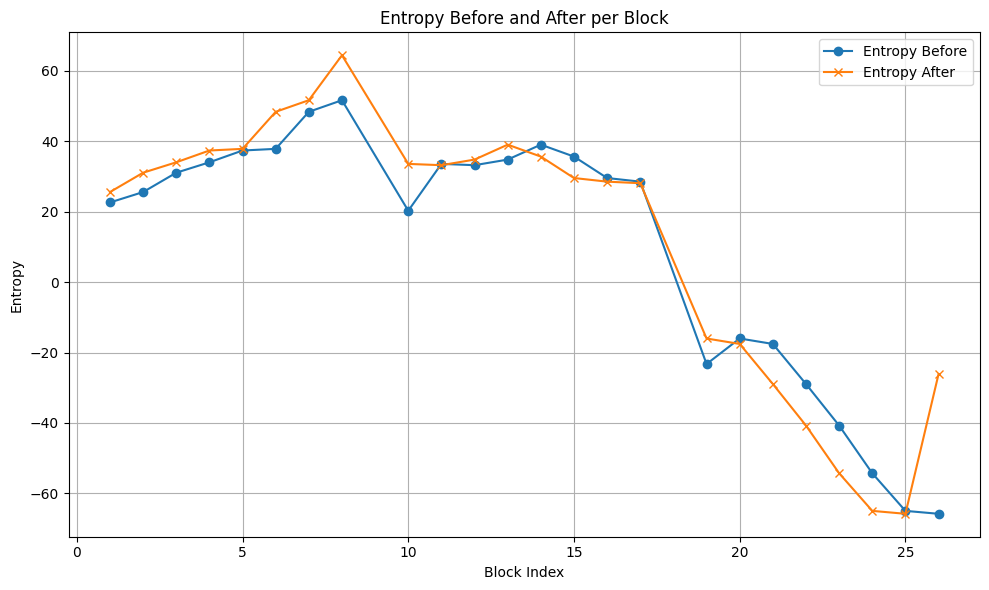

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_stats['block_index'], df_stats['entropy_before'], label='Entropy Before', marker='o')
plt.plot(df_stats['block_index'], df_stats['entropy_after'], label='Entropy After', marker='x')
plt.xlabel('Block Index')
plt.ylabel('Entropy')
plt.title('Entropy Before and After per Block')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

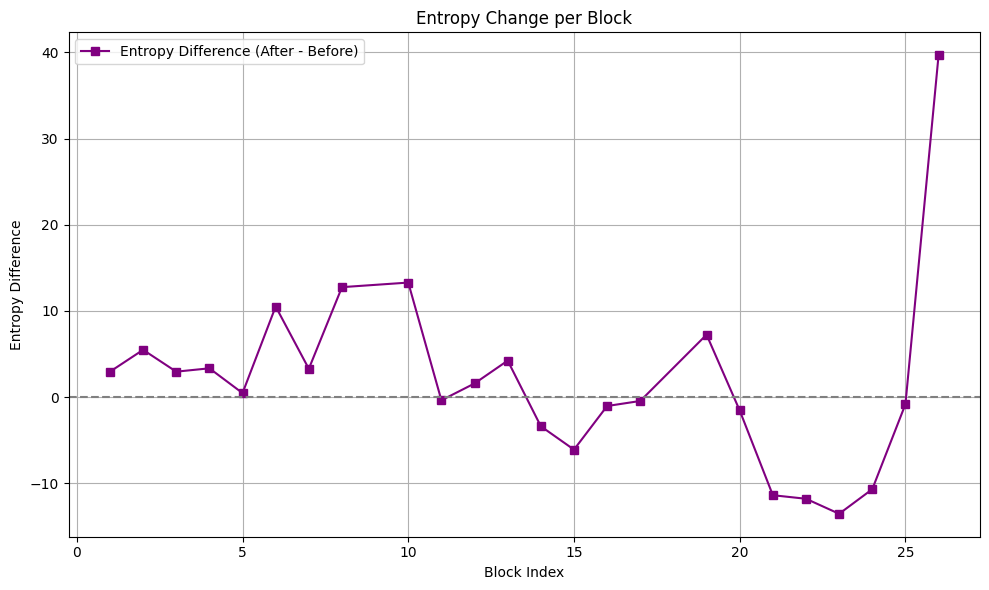

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_stats['block_index'], df_stats['entropy_diff'], label='Entropy Difference (After - Before)', color='purple', marker='s')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Block Index')
plt.ylabel('Entropy Difference')
plt.title('Entropy Change per Block')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# wilcoxon sign rank test

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import numpy as np
import pandas as pd
import random
from scipy.stats import ks_2samp

# 固定隨機種子
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seed(7)
device = torch.device("cpu")

# 用來儲存 activations
activations_pretrained = []

# Hook 函數
def hook_fn_pretrained(module, input, output):
    activations_pretrained.append(output.detach().clone().cpu())

# 判斷是否有子模組
def has_children(module):
    return len(list(module.children())) > 0

# 註冊 hook 並執行 forward pass
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    activations_pretrained.clear()

    if weights:
        checkpoint = torch.load(weights, weights_only=True, map_location="cpu")
        model.load_state_dict(checkpoint['state_dict'], strict=False)

    for stage in model.children():
        if isinstance(stage, torch.nn.Sequential):
            for unit in stage:
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)

    input_tensor = torch.randn(1, 3, 32, 32, device=device)
    model(input_tensor)

    for hook in hooks:
        hook.remove()

# 載入模型
def load_pretrained_model():
    import sys
    sys.path.append("/ssd5/Roy/pytorch_resnet_cifar10-master")
    import resnet_cifar10
    arch = "resnet56"
    model = resnet_cifar10.__dict__[arch]()
    path = f"/ssd5/Roy/pytorch_resnet_cifar10-master/pretrained_models/{arch}.th"
    checkpoint = torch.load(path, map_location="cpu")
    state_dict = checkpoint['state_dict']
    new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    return model

# 去除極端值
def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return data[(data >= lower) & (data <= upper)]

# === 主流程 ===
hooks = []
model = load_pretrained_model()
get_activations_from_model(model, hook_fn_pretrained, hooks)
acts = activations_pretrained.copy()
n = len(acts)
segment_size = n // 3

segments = [
    range(1, segment_size),
    range(segment_size, 2 * segment_size),
    range(2 * segment_size, n)
]

from scipy.stats import wilcoxon  # ✅ 加這行替代 KS/MWU

# 其他程式碼保持一樣...

rows = []
for seg_idx, segment in enumerate(segments, 1):
    for i in segment:
        act1 = remove_outliers(acts[i - 1].numpy().flatten())
        act2 = remove_outliers(acts[i].numpy().flatten())

        # 對齊長度（配對檢定必須等長）
        min_len = min(len(act1), len(act2))
        act1 = act1[:min_len]
        act2 = act2[:min_len]

        # ✅ Wilcoxon 配對樣本檢定
        try:
            stat, p_val = wilcoxon(act1, act2)
        except ValueError:
            stat, p_val = np.nan, np.nan

        sig = "*" if p_val < 0.05 else ""
        rows.append([
            seg_idx,
            i,
            acts[i].shape,
            np.mean(act2),
            np.std(act2),
            stat,
            p_val,
            sig
        ])

# 建立結果表
df = pd.DataFrame(rows, columns=[
    "Segment", "Block Index", "Shape", "Mean", "Std", 
    "Wilcoxon Stat", "P-Value", "Sig"
])

df


/tmp/ipykernel_3304897/1208582400.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location="cpu")


,Segment,Block Index,Shape,Mean,Std,Wilcoxon Stat,P-Value,Sig
0,1,1,"(1, 16, 32, 32)",0.840675,0.929962,47339359.0,2.673227e-20,*
1,1,2,"(1, 16, 32, 32)",0.947440,1.010389,46885218.0,3.526564e-31,*
2,1,3,"(1, 16, 32, 32)",1.046526,1.077027,49592541.0,5.659159e-23,*
3,1,4,"(1, 16, 32, 32)",1.127572,1.111663,52812772.5,1.890554e-15,*
4,1,5,"(1, 16, 32, 32)",1.226799,1.196738,50357556.0,1.243112e-18,*
5,1,6,"(1, 16, 32, 32)",1.373763,1.173455,46809849.5,2.977818e-104,*
6,1,7,"(1, 16, 32, 32)",1.506211,1.138499,53604350.0,6.421714e-40,*
7,1,8,"(1, 16, 32, 32)",1.571013,1.090325,59696209.5,1.366369e-10,*
8,2,9,"(1, 32, 16, 16)",0.870229,1.018301,7637890.0,0.000000e+00,*
9,2,10,"(1, 32, 16, 16)",0.914809,0.999528,10705212.0,3.150070e-14,*


# 距離方法 EMD

In [12]:
import os
import torch
import numpy as np
import pandas as pd
import torchvision.models as models
from scipy.stats import wasserstein_distance, entropy  # 用於計算 EMD 和 KL 散度
from scipy.spatial.distance import jensenshannon  # JS 散度
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seed(5)

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = '4'
torch.cuda.set_device(0)
device = torch.device("cuda")

activations_pretrained = []

def hook_fn_pretrained(module, input, output):
    activations_pretrained.append(output.detach().clone().cpu())

def has_children(module):
    return len(list(module.children())) > 0

def get_activations_from_model(model, hook_fn, hooks, weights=None):
    model.eval()
    activations_pretrained.clear()

    if weights:
        checkpoint = torch.load(weights, weights_only=True, map_location=device)
        model.load_state_dict(checkpoint['state_dict'], strict=False)

    for stage in model.children():
        if isinstance(stage, torch.nn.Sequential):
            for unit in stage:
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)

    input_tensor = torch.randn(1, 3, 32, 32, device=device)
    model(input_tensor)

    for hook in hooks:
        hook.remove()

def load_pretrained_model():
    import sys
    sys.path.append("/ssd5/Roy/pytorch_resnet_cifar10-master")
    import resnet_cifar10
    model = resnet_cifar10.__dict__["resnet56"]()
    path = os.path.join('/ssd5/Roy/pytorch_resnet_cifar10-master/pretrained_models', 'resnet56.th')
    checkpoint = torch.load(path)
    state_dict = checkpoint['state_dict']
    new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    model.to(device)
    return model

def emd_distance(features1, features2):
    return wasserstein_distance(features1.flatten(), features2.flatten())

def to_probability_minmax(features):
    features = (features - np.min(features)) / (np.max(features) - np.min(features) + 1e-10)
    return features / np.sum(features)

def total_variation_distance(features1, features2):
    if len(features1) != len(features2):
        return 9999999
    else:
        p1, p2 = to_probability_minmax(features1), to_probability_minmax(features2)
        return 0.5 * np.sum(np.abs(p1 - p2))

def js_divergence(features1, features2):
    if len(features1) != len(features2):
        return 9999999
    else:
        p1, p2 = to_probability_minmax(features1), to_probability_minmax(features2)
        return jensenshannon(p1, p2)

def kl_divergence(features1, features2):
    if len(features1) != len(features2):
        return 9999999
    else:
        p1, p2 = to_probability_minmax(features1), to_probability_minmax(features2)
        return entropy(p1 + 1e-10, p2 + 1e-10)

def remove_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return data[(data >= lower) & (data <= upper)]

pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, [])
activations_pretrained_copy = activations_pretrained.copy()

rows = []
n = len(activations_pretrained_copy)
for i in range(1, n):
    act_before_pre = activations_pretrained_copy[i-1].numpy().flatten()
    act_after_pre = activations_pretrained_copy[i].numpy().flatten()

    # act_before_pre = remove_outliers(act_before_pre)
    # act_after_pre = remove_outliers(act_after_pre)

    emd_pre = emd_distance(act_before_pre, act_after_pre)
    tv_pre = total_variation_distance(act_before_pre, act_after_pre)
    js_pre = js_divergence(act_before_pre, act_after_pre)
    kl_pre = kl_divergence(act_before_pre, act_after_pre)

    sig_pre = "*" if emd_pre > 0.05 else ""
    # sig_pre = "*" if tv_pre > 0.1 else ""
    # sig_pre = "*" if js_pre > 0.15 else ""
    # sig_pre = "*" if kl_pre > 0.2 else ""

    mean_pre = np.mean(act_after_pre)
    std_pre = np.std(act_after_pre)
    output_shape = activations_pretrained_copy[i].shape
    
    rows.append([i, output_shape, mean_pre, std_pre, emd_pre, tv_pre, js_pre, kl_pre, sig_pre])

columns = ['block_index', 'output shape', 'mean of pretrained', 'std of pretrained', 
           'EMD of pretrained', 'TV of pretrained', 'JS of pretrained', 'KL of pretrained', 'sig_pre']
df_stats = pd.DataFrame(rows, columns=columns)

display(df_stats.style.hide(axis="index"))


/tmp/ipykernel_1110793/3951292640.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


block_index,output shape,mean of pretrained,std of pretrained,EMD of pretrained,TV of pretrained,JS of pretrained,KL of pretrained,sig_pre
1,"torch.Size([1, 16, 32, 32])",1.120218,1.534089,0.254968,0.174959,0.222365,0.531334,*
2,"torch.Size([1, 16, 32, 32])",1.195671,1.687663,0.083152,0.123089,0.177032,0.370148,*
3,"torch.Size([1, 16, 32, 32])",1.289947,1.801235,0.094275,0.088951,0.140776,0.193885,*
4,"torch.Size([1, 16, 32, 32])",1.440451,1.908429,0.150525,0.123525,0.182450,0.240714,*
5,"torch.Size([1, 16, 32, 32])",1.571974,2.038213,0.131523,0.063721,0.101804,0.093677,*
6,"torch.Size([1, 16, 32, 32])",1.702881,1.987053,0.158339,0.137534,0.198432,0.406951,*
7,"torch.Size([1, 16, 32, 32])",1.764647,1.943210,0.113400,0.131690,0.177967,0.283734,*
8,"torch.Size([1, 16, 32, 32])",1.810371,1.800563,0.116465,0.122460,0.160852,0.256644,*
9,"torch.Size([1, 32, 16, 16])",1.139218,1.601428,0.671227,9999999.000000,9999999.000000,9999999.000000,*
10,"torch.Size([1, 32, 16, 16])",1.147147,1.504315,0.076308,0.093671,0.155412,0.199502,*
